In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
# Check Kaggle's directory structure
print("Available input directories:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Directory: {dirname}")
    if len(filenames) > 0:
        print(f"  Sample files: {filenames[:3]}")

Available input directories:
Directory: /kaggle/input
Directory: /kaggle/input/asl-signs
  Sample files: ['sign_to_prediction_index_map.json', 'train.csv']
Directory: /kaggle/input/asl-signs/train_landmark_files
Directory: /kaggle/input/asl-signs/train_landmark_files/36257
  Sample files: ['3762317508.parquet', '1613088982.parquet', '4161325779.parquet']
Directory: /kaggle/input/asl-signs/train_landmark_files/25571
  Sample files: ['867304231.parquet', '3857133971.parquet', '3549313597.parquet']
Directory: /kaggle/input/asl-signs/train_landmark_files/55372
  Sample files: ['3987235427.parquet', '3213314543.parquet', '347178606.parquet']
Directory: /kaggle/input/asl-signs/train_landmark_files/26734
  Sample files: ['39347591.parquet', '744758408.parquet', '1160711543.parquet']
Directory: /kaggle/input/asl-signs/train_landmark_files/16069
  Sample files: ['2285328250.parquet', '2596699720.parquet', '1733649131.parquet']
Directory: /kaggle/input/asl-signs/train_landmark_files/53618
  Samp

In [4]:
# Find the dataset directory
def find_dataset_directory():
    """Locate the dataset directory in Kaggle input"""
    # Common directory pattern for sign language datasets
    for dirname, _, filenames in os.walk('/kaggle/input'):
        if 'train.csv' in filenames:
            return dirname
    raise FileNotFoundError("Could not find train.csv in input directories")

# Get the dataset path
try:
    DATASET_DIR = find_dataset_directory()
    print(f"Found dataset at: {DATASET_DIR}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Fallback option
    DATASET_DIR = "/kaggle/input/asl-signs"
    print(f"Using fallback path: {DATASET_DIR}")

# Define paths
TRAIN_CSV = os.path.join(DATASET_DIR, 'train.csv')
OUTPUT_DIR = '/kaggle/working'

Found dataset at: /kaggle/input/asl-signs


In [5]:
class SignLanguageDataset(Dataset):
    def __init__(self, landmark_paths, labels=None, max_frames=100, landmark_types=None, base_path=''):
        """
        Dataset for sign language landmarks
        
        Args:
            landmark_paths: List of paths to parquet files
            labels: List of sign labels (None for test)
            max_frames: Maximum number of frames to consider
            landmark_types: List of landmark types to include (default: all)
            base_path: Base directory for landmark files
        """
        self.landmark_paths = landmark_paths
        self.labels = labels
        self.max_frames = max_frames
        self.landmark_types = landmark_types or ['face', 'left_hand', 'pose', 'right_hand']
        self.base_path = base_path
        
        # Define landmark counts based on MediaPipe
        self.landmark_counts = {
            'face': 468,
            'left_hand': 21,
            'pose': 33,
            'right_hand': 21
        }
        
        # Calculate total feature dimension
        self.feature_dim = sum(self.landmark_counts[t] * 3 for t in self.landmark_types)
        
    def __len__(self):
        return len(self.landmark_paths)
    
    def __getitem__(self, idx):
        # Construct full path - handle both relative and absolute paths
        path = self.landmark_paths[idx]
        if not os.path.isabs(path):
            path = os.path.join(self.base_path, path)
        
        # Load landmark data from parquet file
        try:
            df = pd.read_parquet(path)
        except Exception as e:
            print(f"Error loading file {path}: {e}")
            # Return empty tensors in case of error
            empty_features = np.zeros((self.max_frames, self.feature_dim))
            empty_mask = np.zeros(self.max_frames)
            if self.labels is not None:
                return torch.FloatTensor(empty_features), torch.FloatTensor(empty_mask), self.labels[idx]
            else:
                return torch.FloatTensor(empty_features), torch.FloatTensor(empty_mask)
            
        # Get all frames in the sequence
        frames = df['frame'].unique()
        frames = sorted(frames)[:self.max_frames]  # Limit to max_frames
        num_frames = len(frames)
        
        # Initialize feature tensor
        features = np.zeros((self.max_frames, self.feature_dim))
        
        # Fill in features for available frames
        for i, frame_idx in enumerate(frames):
            if i >= self.max_frames:
                break
                
            frame_data = df[df['frame'] == frame_idx]
            
            feature_offset = 0
            for landmark_type in self.landmark_types:
                type_data = frame_data[frame_data['type'] == landmark_type]
                num_landmarks = self.landmark_counts[landmark_type]
                
                # Check if we have data for this type
                if len(type_data) > 0:
                    # Get coordinates for each landmark
                    for coord in ['x', 'y', 'z']:
                        coord_data = np.zeros(num_landmarks)
                        for _, row in type_data.iterrows():
                            if 0 <= row['landmark_index'] < num_landmarks:
                                coord_data[int(row['landmark_index'])] = row[coord]
                        
                        # Add to features
                        features[i, feature_offset:feature_offset + num_landmarks] = coord_data
                        feature_offset += num_landmarks
                else:
                    # Skip this landmark type if no data
                    feature_offset += num_landmarks * 3
        
        # Create a mask for valid frames
        mask = np.zeros(self.max_frames)
        mask[:num_frames] = 1
        
        if self.labels is not None:
            return torch.FloatTensor(features), torch.FloatTensor(mask), self.labels[idx]
        else:
            return torch.FloatTensor(features), torch.FloatTensor(mask)

In [19]:
class DynamicPatching(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_sizes=[3, 5, 10], n_layers=1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_sizes = kernel_sizes
        
        # Create separate convolutional embedding for each kernel size
        self.patch_embeddings = nn.ModuleList()
        for kernel_size in kernel_sizes:
            layers = []
            for i in range(n_layers):
                if i == 0:
                    layers.append(nn.Conv1d(
                        in_channels=input_dim,
                        out_channels=hidden_dim,
                        kernel_size=kernel_size,
                        padding='same'
                    ))
                else:
                    layers.append(nn.Conv1d(
                        in_channels=hidden_dim,
                        out_channels=hidden_dim,
                        kernel_size=kernel_size,
                        padding='same'
                    ))
                layers.append(nn.ReLU())
            self.patch_embeddings.append(nn.Sequential(*layers))
        
        # Layer norm with correct normalized_shape
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Combine with weighted sum
        self.patch_weights = nn.Parameter(torch.ones(len(kernel_sizes)) / len(kernel_sizes))
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x, mask=None):
        # x: [B, T, input_dim]
        batch_size, seq_len, _ = x.shape
        
        # Transpose for conv1d: [B, input_dim, T]
        x = x.transpose(1, 2)
        
        patch_outputs = []
        for embedding in self.patch_embeddings:
            patch_out = embedding(x)  # [B, hidden_dim, T]
            patch_outputs.append(patch_out.transpose(1, 2))  # [B, T, hidden_dim]
        
        # Apply weighted sum with learnable weights
        weights = self.softmax(self.patch_weights)
        combined = torch.zeros_like(patch_outputs[0])
        for i, patch_output in enumerate(patch_outputs):
            combined += weights[i] * patch_output
        
        # Apply layer norm with correct dimensions
        # Since combined is [B, T, hidden_dim], the layer_norm expects normalized_shape=[hidden_dim]
        normalized = self.layer_norm(combined)
        
        if mask is not None:
            return normalized, mask
        return normalized

In [33]:
class ByteLatentTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_heads=4, n_layers=3, 
                 kernel_sizes=[3, 5, 10], dropout=0.1):
        super().__init__()
        
        self.patching = DynamicPatching(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            kernel_sizes=kernel_sizes
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_layers
        )
        
        self.fc_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x, mask=None):
        # Apply dynamic patching
        if mask is not None:
            x, mask = self.patching(x, mask)
        else:
            x = self.patching(x)
        
        # Apply transformer encoder
        if mask is not None:
            x = self.transformer_encoder(x, src_key_padding_mask=mask)
        else:
            x = self.transformer_encoder(x)
        
        # Global pooling (mean of non-masked positions)
        if mask is not None:
            # Ensure mask is boolean type
            if not mask.dtype == torch.bool:
                mask = mask.bool()
                
            # Create an inverted mask for averaging: True for real tokens (not padding), False for padding
            attention_mask = (~mask).float().unsqueeze(-1)  # This is now 1 for tokens to keep, 0 for padding
            
            # Sum all non-masked token embeddings and divide by count
            pooled = (x * attention_mask).sum(dim=1) / attention_mask.sum(dim=1).clamp(min=1e-9)
        else:
            # Simple mean pooling if no mask
            pooled = x.mean(dim=1)
        
        # Apply classification head
        output = self.fc_head(pooled)
        
        return output

In [34]:
def train_model(model, train_loader, val_loader, n_epochs=10, lr=1e-4, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (features, mask, labels) in enumerate(train_loader):
            features = features.to(device)
            if mask is not None:
                # Ensure mask is the correct type before sending to device
                if not mask.dtype == torch.bool:
                    mask = mask.bool()
                mask = mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(features, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch: {epoch+1}/{n_epochs} | Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}%')
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for features, mask, labels in val_loader:
                features = features.to(device)
                if mask is not None:
                    # Ensure mask is the correct type before sending to device
                    if not mask.dtype == torch.bool:
                        mask = mask.bool()
                    mask = mask.to(device)
                labels = labels.to(device)
                
                outputs = model(features, mask)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'\nEpoch: {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | '
              f'Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Model saved with validation accuracy: {val_acc:.2f}%')
        
        scheduler.step()
    
    return model, history

In [35]:

def analyze_data_distribution(train_df):
    """Analyze the distribution of signs in the dataset"""
    plt.figure(figsize=(12, 6))
    sign_counts = train_df['sign'].value_counts()
    
    print(f"Total number of unique signs: {len(sign_counts)}")
    print(f"Most common signs: {sign_counts.head(10).index.tolist()}")
    print(f"Least common signs: {sign_counts.tail(10).index.tolist()}")
    
    plt.subplot(1, 2, 1)
    sns.histplot(sign_counts, bins=30)
    plt.xlabel('Count per sign')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sign Counts')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=sign_counts.index[:20], y=sign_counts.values[:20])
    plt.xticks(rotation=90)
    plt.xlabel('Sign')
    plt.ylabel('Count')
    plt.title('Top 20 Most Common Signs')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sign_distribution.png'))
    plt.show()
    
    return sign_counts


In [36]:
def analyze_sequence_lengths(train_df, sample_size=1000):
    """Analyze the distribution of sequence lengths"""
    # Sample to avoid loading all files
    sampled_df = train_df.sample(min(sample_size, len(train_df)), random_state=42)
    
    sequence_lengths = []
    for path in tqdm(sampled_df['path'], desc="Analyzing sequence lengths"):
        try:
            full_path = os.path.join(DATASET_DIR, path)
            df = pd.read_parquet(full_path)
            num_frames = len(df['frame'].unique())
            sequence_lengths.append(num_frames)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    plt.figure(figsize=(10, 5))
    sns.histplot(sequence_lengths, bins=50)
    plt.xlabel('Sequence Length (Frames)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sequence Lengths')
    plt.axvline(x=np.percentile(sequence_lengths, 95), color='r', linestyle='--', 
                label=f'95th percentile: {np.percentile(sequence_lengths, 95):.0f} frames')
    plt.axvline(x=np.median(sequence_lengths), color='g', linestyle='--', 
                label=f'Median: {np.median(sequence_lengths):.0f} frames')
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sequence_lengths.png'))
    plt.show()
    
    print(f"Mean sequence length: {np.mean(sequence_lengths):.2f} frames")
    print(f"Median sequence length: {np.median(sequence_lengths):.2f} frames")
    print(f"95th percentile length: {np.percentile(sequence_lengths, 95):.2f} frames")
    
    return sequence_lengths


In [37]:
def train_with_augmentation(model, train_loader, val_loader, n_epochs=10, lr=1e-4):
    """Train with data augmentation strategies"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Data augmentation functions
    def time_warp(x, mask, factor=0.2):
        """Stretch or compress sequence in time dimension"""
        b, t, d = x.shape
        if torch.rand(1).item() > 0.5:
            # Apply time warping
            orig_len = mask.sum(dim=1).int()
            max_warp = (orig_len * factor).int()
            warp_len = torch.randint(-max_warp, max_warp+1, (b,))
            warp_len = torch.clamp(orig_len + warp_len, min=10, max=t-1)
            
            new_x = torch.zeros_like(x)
            new_mask = torch.zeros_like(mask)
            
            for i in range(b):
                # Resize via linear interpolation
                if orig_len[i] > 0:  # Avoid empty sequences
                    indices = torch.linspace(0, orig_len[i]-1, warp_len[i])
                    indices = indices.to(torch.long)
                    valid_x = x[i, :orig_len[i]]
                    new_x[i, :warp_len[i]] = valid_x[indices]
                    new_mask[i, :warp_len[i]] = 1
            
            return new_x, new_mask
        return x, mask
    
    def random_mask(x, mask, mask_ratio=0.1):
        """Randomly mask some frames"""
        if torch.rand(1).item() > 0.5:
            b, t, d = x.shape
            for i in range(b):
                valid_length = int(mask[i].sum().item())
                if valid_length > 3:  # Don't mask if sequence is too short
                    mask_length = int(valid_length * mask_ratio)
                    start_idx = torch.randint(0, valid_length - mask_length, (1,)).item()
                    x[i, start_idx:start_idx+mask_length] = 0
        return x, mask
    
    def channel_mask(x, mask, feature_mask_ratio=0.05):
        """Randomly mask some feature channels"""
        if torch.rand(1).item() > 0.5:
            b, t, d = x.shape
            mask_size = int(d * feature_mask_ratio)
            for i in range(b):
                mask_indices = torch.randperm(d)[:mask_size]
                x[i, :, mask_indices] = 0
        return x, mask
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    
    best_val_acc = 0.0
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Train]')
        for features, mask, labels in pbar:
            features, mask, labels = features.to(device), mask.to(device), labels.to(device)
            
            # Apply augmentations
            features, mask = time_warp(features, mask)
            features, mask = random_mask(features, mask)
            features, mask = channel_mask(features, mask)
            
            optimizer.zero_grad()
            outputs = model(features, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': train_loss/len(train_loader), 'acc': 100.*correct/total})
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for features, mask, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Val]'):
                features, mask, labels = features.to(device), mask.to(device), labels.to(device)
                
                outputs = model(features, mask)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100.*correct/total
        print(f'Validation Acc: {val_acc:.2f}%, Loss: {val_loss/len(val_loader):.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_aug_model.pth'))
        
        scheduler.step()
    
    return model

In [38]:
def main():
    print("Starting BLT Sign Language Classification")
    print(f"Working directory: {os.getcwd()}")
    
    # Load training data
    try:
        train_df = pd.read_csv(TRAIN_CSV)
        print(f"Loaded {len(train_df)} training samples")
    except Exception as e:
        print(f"Error loading train.csv: {e}")
        # Fix the syntax error - remove return statement
        print("Could not load training data. Please check the file path.")
        # Continue with other operations if possible
    
    # Check if training data is loaded before proceeding
    if 'train_df' in locals() and len(train_df) > 0:
        # Analyze data
        print("\nAnalyzing data distribution...")
        sign_counts = analyze_data_distribution(train_df)
        
        print("\nAnalyzing sequence lengths...")
        sequence_lengths = analyze_sequence_lengths(train_df, sample_size=500)
        
        # Calculate recommended max_frames
        recommended_max_frames = int(np.percentile(sequence_lengths, 95))
        print(f"Recommended max_frames: {recommended_max_frames}")
        
        # Create label encoder
        label_encoder = LabelEncoder()
        train_df['label_encoded'] = label_encoder.fit_transform(train_df['sign'])
        num_classes = len(label_encoder.classes_)
        print(f"Number of classes: {num_classes}")
        
        # Save label encoder mapping
        label_mapping = pd.DataFrame({
            'sign': label_encoder.classes_,
            'label_encoded': range(len(label_encoder.classes_))
        })
        label_mapping.to_csv(os.path.join(OUTPUT_DIR, 'label_mapping.csv'), index=False)
        
        # Split data
        train_indices, val_indices = train_test_split(
            range(len(train_df)), test_size=0.2, random_state=42, 
            stratify=train_df['sign']
        )
        
        # Create datasets
        train_dataset = SignLanguageDataset(
            landmark_paths=train_df['path'].iloc[train_indices].tolist(),
            labels=train_df['label_encoded'].iloc[train_indices].tolist(),
            max_frames=recommended_max_frames,
            base_path=DATASET_DIR
        )
        
        val_dataset = SignLanguageDataset(
            landmark_paths=train_df['path'].iloc[val_indices].tolist(),
            labels=train_df['label_encoded'].iloc[val_indices].tolist(),
            max_frames=recommended_max_frames,
            base_path=DATASET_DIR
        )
        
        print(f"Feature dimension: {train_dataset.feature_dim}")
        
        # Create dataloaders - adjust batch size based on your GPU memory
        # Start with smaller batch size for Kaggle
        batch_size = 16  # Adjust based on available memory
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False, num_workers=2)
        
        # Initialize model
        model = ByteLatentTransformer(
            input_dim=train_dataset.feature_dim,
            hidden_dim=192,  # Reduced for memory constraints
            output_dim=num_classes,
            n_layers=3,  # Use n_layers instead of num_layers
            n_heads=4,
            kernel_sizes=[3, 5, 10],
            dropout=0.1
        )
        
        # Check model size
        param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model trainable parameters: {param_count / 1e6:.2f}M")
        
        # Train model
        print("\nStarting training...")
        model, history = train_model(
            model, 
            train_loader, 
            val_loader, 
            n_epochs=15,
            lr=5e-5  # Lower learning rate for stability
        )
        
        # Save final model
        torch.save({
            'model_state_dict': model.state_dict(),
            'label_encoder': label_encoder.classes_,
            'feature_dim': train_dataset.feature_dim,
            'hidden_dim': 192,
            'num_classes': num_classes,
            'max_frames': recommended_max_frames
        }, os.path.join(OUTPUT_DIR, 'final_model.pth'))
        
        print("Training completed. Model saved to working directory.")
    else:
        print("Could not proceed with training due to missing data.")


Starting BLT Sign Language Classification
Working directory: /kaggle/working
Loaded 94477 training samples

Analyzing data distribution...
Total number of unique signs: 250
Most common signs: ['listen', 'look', 'shhh', 'donkey', 'mouse', 'hear', 'uncle', 'duck', 'bird', 'pretend']
Least common signs: ['have', 'table', 'night', 'jacket', 'down', 'dance', 'person', 'beside', 'vacuum', 'zipper']


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


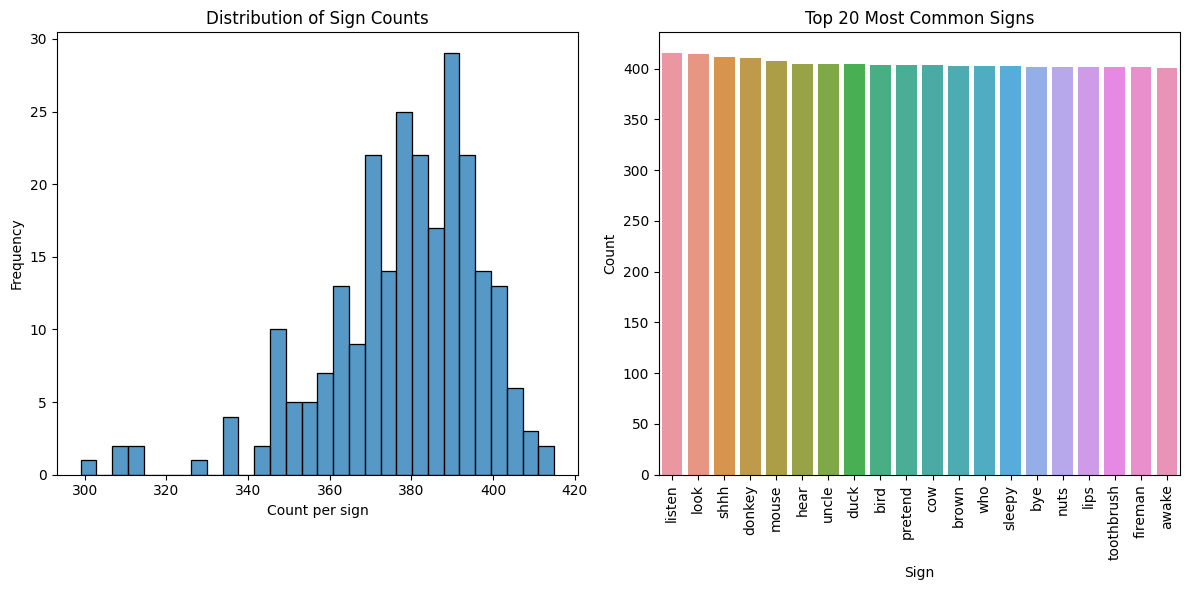


Analyzing sequence lengths...


Analyzing sequence lengths:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


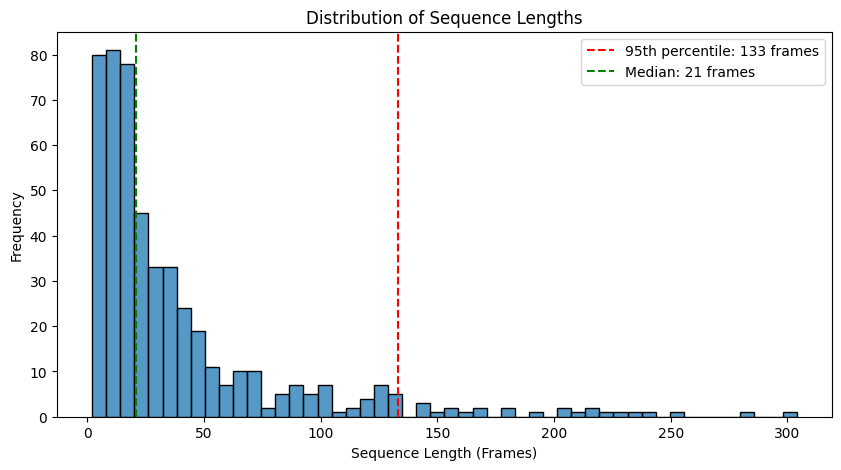

Mean sequence length: 39.51 frames
Median sequence length: 21.00 frames
95th percentile length: 133.00 frames
Recommended max_frames: 133
Number of classes: 250
Feature dimension: 1629
Model trainable parameters: 7.05M

Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch: 1/15 | Batch: 0/4724 | Loss: nan | Acc: 0.00%


In [ ]:
# Run the main function when executed
if __name__ == "__main__":
    main()